In [1]:
!pip install opencv-python-headless matplotlib numpy easyocr imutils kaggle

In [2]:
!pip install matplotlib

In [3]:
import os
import zipfile
import shutil
import glob

In [4]:
print(os.getcwd())

C:\Users\ADMIN\OneDrive\Desktop\Project2


In [5]:
zip_path=r"C:\Users\ADMIN\Downloads\ANPR_DATASET.zip"
extract_dir="anpr_dataset"

In [6]:

with zipfile.ZipFile(zip_path,'r') as zip_ref:



    zip_ref.extractall(extract_dir) 
print("Dataset extracted successfully in: ",extract_dir)
print("Folder inside:",os.listdir(extract_dir))

Dataset extracted successfully in:  anpr_dataset
Folder inside: ['annotations', 'images']


In [7]:
images_path = os.path.join(extract_dir,"images")
annotations_path = os.path.join(extract_dir,"annotations")
print("Images folder: ",os.path.exists(images_path))
print("Annotations folder:",os.path.exists(annotations_path))

Images folder:  True
Annotations folder: True


In [8]:

sample_images=glob.glob(os.path.join(images_path,"*.png"))
sample_annotations=glob.glob(os.path.join(annotations_path,"*.xml"))
print(f"Total images found:{len(sample_images)}")
print(f"Total annotations found:{len(sample_annotations)}")

print("\nSample image file: ", sample_images[0])
print("sample annotation file: ",sample_annotations[0])

Total images found:433
Total annotations found:433

Sample image file:  anpr_dataset\images\Cars0.png
sample annotation file:  anpr_dataset\annotations\Cars0.xml


In [9]:
import xml.etree.ElementTree as ET

In [10]:
sample_xml = r"anpr_dataset\annotations\Cars0.xml"
tree = ET.parse(sample_xml) 
root = tree.getroot()
print("Filename:",root.find('filename').text) 
for obj in root.findall('object'): 
    print("class:",obj.find('name').text) 
    bbox = obj.find('bndbox')
    print("BBox cords",
         bbox.find('xmin').text,bbox.find('ymin').text,
         bbox.find('xmax').text,bbox.find('ymax').text)

Filename: Cars0.png
class: licence
BBox cords 226 125 419 173


In [11]:
import cv2
from matplotlib import pyplot as plt

In [12]:
Sample_img_path = r"anpr_dataset\images\Cars0.png"
Sample_xml_path = r"anpr_dataset\annotations\Cars0.xml"

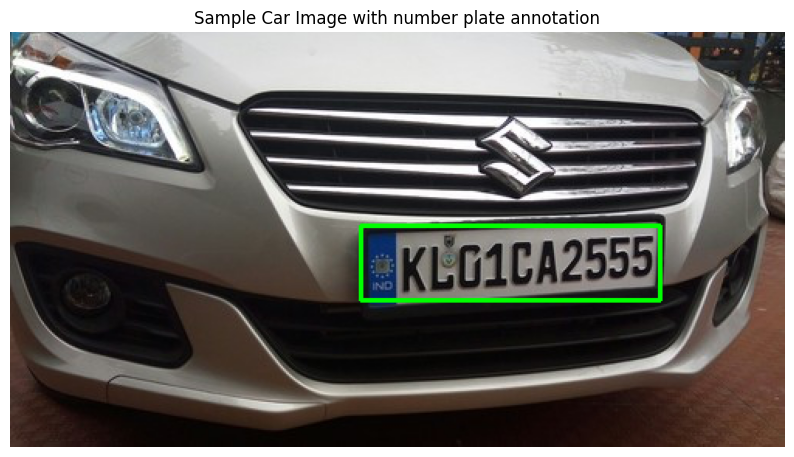

In [13]:
img = cv2.imread(Sample_img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
tree = ET.parse(Sample_xml_path) 
root = tree.getroot()

for obj in root.findall('object'):
    bbox= obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax=  int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    cv2.rectangle(img_rgb,(xmin,ymin),(xmax,ymax),(0,255,0),2)
plt.figure(figsize=(10,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Sample Car Image with number plate annotation")
plt.show()


In [14]:
import random

In [15]:
images_path = "anpr_dataset/images"
annotations_path = "anpr_dataset/annotations"

images = glob.glob(os.path.join(images_path, "*.png"))

random.seed(42)
random.shuffle(images)

split_ratio = 0.8
split_index = int(len(images) * split_ratio)

train_images = images[:split_index]
val_images = images[split_index:]

train_dir = "dataset/train"
val_dir = "dataset/val"

# Create folders
for folder in [train_dir, val_dir]:
    for sub in ["images", "annotations"]:
        os.makedirs(os.path.join(folder, sub), exist_ok=True)

def move_files(image_list, dest_folder):
    for img_path in image_list:
        filename = os.path.basename(img_path)

        # copy image
        shutil.copy(img_path, os.path.join(dest_folder, "images", filename))

        # matching annotation
        xml_name = filename.replace(".png", ".xml")
        xml_path = os.path.join(annotations_path, xml_name)

        # copy annotation if exists
        if os.path.exists(xml_path):
            shutil.copy(xml_path, os.path.join(dest_folder, "annotations", xml_name))

# move files
move_files(train_images, train_dir)
move_files(val_images, val_dir)

print("Train/Validation split done!")

Train/Validation split done!


In [16]:
from ultralytics import YOLO 
model=YOLO("yolov8s.pt")
result = model(r"anpr_dataset\images\Cars0.png")
result[0].show()


image 1/1 C:\Users\ADMIN\OneDrive\Desktop\Project2\anpr_dataset\images\Cars0.png: 352x640 1 car, 905.3ms
Speed: 24.7ms preprocess, 905.3ms inference, 72.3ms postprocess per image at shape (1, 3, 352, 640)


In [17]:
import xml.etree.ElementTree as ET
import os

In [18]:
from PIL import Image

In [19]:
def convert_xml_to_yolo(xml_file, img_width, img_height):  
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    yolo_lines = []
    
    for obj in root.findall('object'):
        class_id = 0  # Only one class: Number Plate
        
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        
        yolo_lines.append(
            f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        )
        
    return yolo_lines


In [20]:
def process_folder(folder_path):  
    img_folder = os.path.join(folder_path, "images")  
    ann_folder = os.path.join(folder_path, "annotations")  
    yolo_folder = os.path.join(folder_path, "labels")  

    os.makedirs(yolo_folder, exist_ok=True)

    # Read all PNG images
    img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(".png")]

    for img_file in img_files:
        img_path = os.path.join(img_folder, img_file)
        ann_file = img_file.replace(".png", ".xml")
        ann_path = os.path.join(ann_folder, ann_file)

        # Read image size
        with Image.open(img_path) as im:
            width, height = im.size

        # Convert XML to YOLO format
        if os.path.exists(ann_path):
            yolo_lines = convert_xml_to_yolo(ann_path, width, height)
        else:
            yolo_lines = []

        # Create YOLO .txt file
        txt_file = os.path.join(yolo_folder, img_file.replace(".png", ".txt"))
        with open(txt_file, "w") as f:
            f.write("\n".join(yolo_lines))


In [21]:
process_folder(train_dir)
process_folder(val_dir)
print("XML annotations converted to yolo format")

XML annotations converted to yolo format


In [22]:
!pip install --user ultralytics --upgrade
!python -m pip install --upgrade pip --user
from ultralytics import YOLO

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ----------------------------- ---------- 0.8/1.1 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 4.8 MB/s  0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.233
    Uninstalling ultralytics-8.3.233:
      Successfully uninstalled ultralytics-8.3.233


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [23]:
dataset_yaml = """
train: dataset/train/images
val: dataset/val/images

nc: 1
names: ['license']
"""

# Save the yaml file
with open("car_plate_data.yaml", "w") as f:
    f.write(dataset_yaml)

print("Dataset yaml created ")


Dataset yaml created 


In [24]:
model = YOLO("yolov8n.pt")

In [25]:
from ultralytics import YOLO

model = YOLO(r"C:/Users/ADMIN/Downloads/ANPR-ATCC-Infosys-main/ANPR-ATCC-Infosys-main/weights/best.pt")

print("✅ Trained YOLO model loaded successfully!")


✅ Trained YOLO model loaded successfully!


In [30]:
import os
import random

# Path to validation images
val_images_path = os.path.join("dataset/val/images")

# List all image files with correct extensions
val_images = [f for f in os.listdir(val_images_path) if f.endswith((".png", ".jpg", ".jpeg"))]

# Pick a random validation image
test_img = os.path.join(val_images_path, random.choice(val_images))
print("Testing on image:", test_img)


Testing on image: dataset/val/images\Cars118.png


In [31]:
results = model.predict(test_img) 
results[0].plot() 

results[0].save("output/")


image 1/1 C:\Users\ADMIN\OneDrive\Desktop\Project2\dataset\val\images\Cars118.png: 416x640 1 licence, 1218.0ms
Speed: 23.6ms preprocess, 1218.0ms inference, 8.6ms postprocess per image at shape (1, 3, 416, 640)


'output/'


image 1/1 C:\Users\ADMIN\OneDrive\Desktop\Project2\dataset\val\images\Cars118.png: 416x640 1 licence, 324.1ms
Speed: 44.0ms preprocess, 324.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


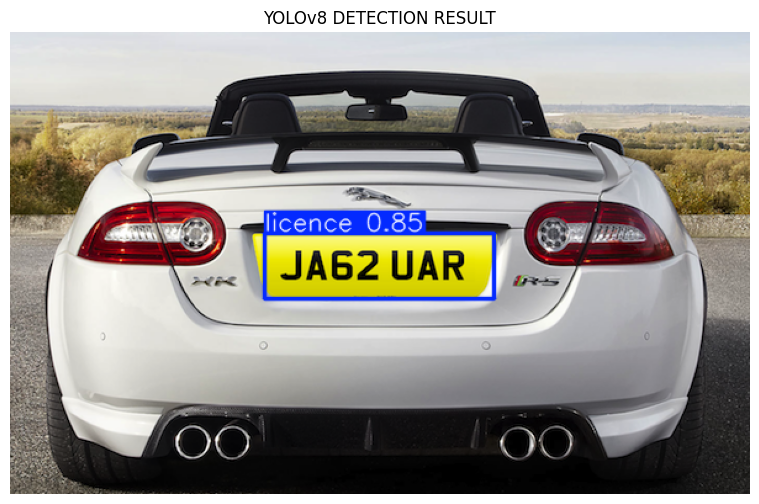

In [32]:
from matplotlib import pyplot as plt
import cv2
results = model.predict(test_img)
img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("YOLOv8 DETECTION RESULT")
plt.show()


In [29]:
import os
import glob
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import easyocr


In [33]:
!pip install easyocr
import easyocr

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


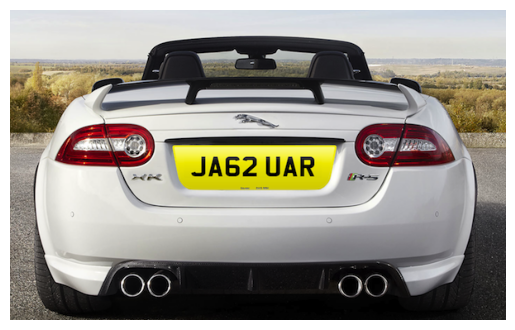


image 1/1 C:\Users\ADMIN\OneDrive\Desktop\Project2\dataset\val\images\Cars118.png: 416x640 1 licence, 189.4ms
Speed: 5.5ms preprocess, 189.4ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 640)


In [35]:
!pip install easyocr

import easyocr
import cv2
from matplotlib import pyplot as plt

# Initialize OCR reader
reader = easyocr.Reader(['en'])

# Load the image
img = cv2.imread(test_img)  # test_img must be a valid image path

# Safety check
if img is None:
    print("❌ Image not found. Check the image path.")
else:
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# YOLO prediction
results = model.predict(test_img)[0]


In [36]:
#Loop over detected objects(plates)
# Eaach box contains box codes which is converting cpu to numpy
for box in results.boxes.xyxy: #xmin,ymin,xmax,ymax
    xmin,ymin,xmax,ymax = map(int,box.cpu().numpy()) #by gpu it is getting errors,Crop the detected plate now
    plate_img = img[ymin:ymax,xmin:xmax] #Crop the detected region into plate,remove background,just plate
    #ocr on cropped plate 
    ocr_result = reader.readtext(plate_img) #List of tuples bbox,text,confidence
    print("Detected number plate text: ",ocr_result)
    #It gives raw confidence
    cv2.rectangle(img_rgb,(xmin,ymin),(xmax,ymax),(0,255,0),2) #To know where the detected plate is by ocr
    if ocr_result:
        text = ocr_result[0][1] #It is the first detected text
         cv2.putText(img_rgb,text,(xmin,ymin-10),
                    cv2.font_hershey_SIMPLEX,1,(255,0,0),2) #T0 give text at above of the plate#Final image of the plate
plt.figure(figsize=(10,6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("YOLOV8+OCR ANPR RESULT")
plt.show()


IndentationError: unexpected indent (1119125932.py, line 13)

C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Detected number plate text: [([[np.int32(11), np.int32(9)], [np.int32(169), np.int32(9)], [np.int32(169), np.int32(45)], [np.int32(11), np.int32(45)]], 'JA62 UAR', np.float64(0.38609456384947416))]


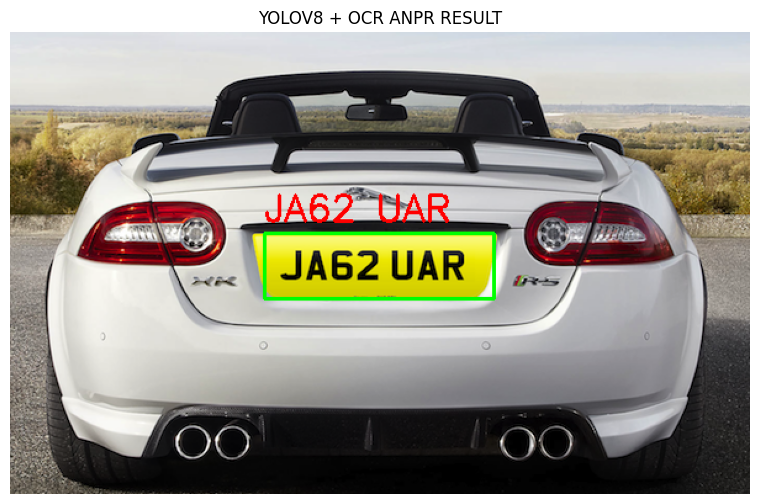

In [37]:
# Loop over detected objects (plates)
# Each box contains box coords which is converting CPU to numpy
for box in results.boxes.xyxy:  # xmin, ymin, xmax, ymax
    
    xmin, ymin, xmax, ymax = map(int, box.cpu().numpy())

    # Crop the detected plate
    plate_img = img[ymin:ymax, xmin:xmax]

    # Apply OCR on cropped plate
    ocr_result = reader.readtext(plate_img)  # List of tuples (bbox, text, confidence)
    print("Detected number plate text:", ocr_result)

    # Draw rectangle around detected plate
    cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # If OCR text is detected
    if ocr_result:
        text = ocr_result[0][1]  # First detected text
        
        cv2.putText(
            img_rgb,
            text,
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,  # ✅ FIXED
            1,
            (255, 0, 0),
            2
        )

# Show final result
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("YOLOV8 + OCR ANPR RESULT")
plt.show()
